In [ ]:
#  Install all required libraries (Colab)
!pip install seaborn imbalanced-learn tensorflow scikit-learn


In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/datasets"
print("Using dataset folder:", BASE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using dataset folder: /content/drive/MyDrive/datasets


In [ ]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


In [ ]:
# Load datasets with correct paths

import pandas as pd

parkinson_df = pd.read_csv("/content/drive/MyDrive/Parkinsson disease.csv")
heart_df     = pd.read_csv("/content/drive/MyDrive/heart.csv")
diabetes_df  = pd.read_csv("/content/drive/MyDrive/diabetes_dataset.csv")

print("Datasets loaded successfully!")
print("Parkinson shape:", parkinson_df.shape)
print("Heart shape:", heart_df.shape)
print("Diabetes shape:", diabetes_df.shape)

# Preview first few rows
parkinson_df.head(), heart_df.head(), diabetes_df.head()




Datasets loaded successfully!
Parkinson shape: (195, 24)
Heart shape: (1025, 14)
Diabetes shape: (200, 9)


(             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
 0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
 1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
 2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
 3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
 4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   
 
    MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
 0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
 1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
 2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
 3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
 4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   
 
    Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  

In [ ]:
# Clean datasets (drop duplicates, handle blanks)
datasets = [parkinson_df, heart_df, diabetes_df]
names = ["Parkinson", "Heart", "Diabetes"]

for df, name in zip(datasets, names):
    df.drop_duplicates(inplace=True)
    df.fillna(df.median(numeric_only=True), inplace=True)
    print(f"{name} cleaned → {df.shape}")


Parkinson cleaned → (195, 24)
Heart cleaned → (302, 14)
Diabetes cleaned → (200, 9)


In [ ]:
from sklearn.preprocessing import StandardScaler

def prepare_xy(df, label_column):
    """
    Prepares numeric features and target for ML/DL.
    Explicitly drops the first column (ID/filename) for Parkinson dataset.
    """
    # Drop the first column if it's non-numeric
    if df.iloc[:,0].dtype == object:
        df = df.drop(df.columns[0], axis=1)

    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['int64', 'float64'])

    # Drop target column from features
    if label_column in numeric_df.columns:
        X = numeric_df.drop(columns=[label_column]).values
    else:
        X = numeric_df.values

    # Target
    y = df[label_column].values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y



In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def split_and_balance(X, y):
    """
    Splits into train/test and applies SMOTE for class balancing.
    """
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    sm = SMOTE(random_state=42)
    Xtr, ytr = sm.fit_resample(Xtr, ytr)
    return Xtr, Xte, ytr, yte


In [ ]:
# Convert Parkinson target to binary
threshold = parkinson_df[parkinson_df.columns[-1]].median()
parkinson_df['target_class'] = (parkinson_df[parkinson_df.columns[-1]] > threshold).astype(int)

# Prepare features and labels
Xp, yp = prepare_xy(parkinson_df, 'target_class')
Xp_tr, Xp_te, yp_tr, yp_te = split_and_balance(Xp, yp)

# Heart
Xh, yh = prepare_xy(heart_df, heart_df.columns[-1])
Xh_tr, Xh_te, yh_tr, yh_te = split_and_balance(Xh, yh)

# Diabetes
Xd, yd = prepare_xy(diabetes_df, diabetes_df.columns[-1])
Xd_tr, Xd_te, yd_tr, yd_te = split_and_balance(Xd, yd)

print("All datasets prepared successfully.")


All datasets prepared successfully.


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def train_ml_models(Xtr, ytr):
    """
    Trains standard ML models: SVM, RandomForest, XGBoost
    """
    models = {
        "SVM": SVC(kernel='rbf', probability=True, C=2, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
        "XGBoost": XGBClassifier(
            max_depth=5,
            learning_rate=0.1,
            n_estimators=300,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42
        )
    }

    for name, model in models.items():
        model.fit(Xtr, ytr)
        print(f"{name} trained.")

    return models


In [ ]:
# Train ML models for Parkinson
ml_p = train_ml_models(Xp_tr, yp_tr)

# Train ML models for Heart
ml_h = train_ml_models(Xh_tr, yh_tr)

# Train ML models for Diabetes
ml_d = train_ml_models(Xd_tr, yd_tr)


SVM trained.
RandomForest trained.
XGBoost trained.
SVM trained.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomForest trained.
XGBoost trained.
SVM trained.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomForest trained.
XGBoost trained.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def build_dl(input_dim):
    """
    Builds a standard feedforward DL model with BatchNorm and Dropout.
    """
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import tensorflow as tf

dl_p = build_dl(Xp_tr.shape[1])
dl_h = build_dl(Xh_tr.shape[1])
dl_d = build_dl(Xd_tr.shape[1])

# Early stopping to avoid overfitting
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train Parkinson DL model
dl_p.fit(Xp_tr, yp_tr, validation_split=0.2, epochs=50, batch_size=32, callbacks=[callback], verbose=1)

# Train Heart DL model
dl_h.fit(Xh_tr, yh_tr, validation_split=0.2, epochs=50, batch_size=32, callbacks=[callback], verbose=1)

# Train Diabetes DL model
dl_d.fit(Xd_tr, yd_tr, validation_split=0.2, epochs=50, batch_size=32, callbacks=[callback], verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.4891 - loss: 1.0660 - val_accuracy: 0.9706 - val_loss: 0.5129
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7523 - loss: 0.4242 - val_accuracy: 0.9412 - val_loss: 0.4407
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8753 - loss: 0.2686 - val_accuracy: 0.9118 - val_loss: 0.4016
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9134 - loss: 0.1895 - val_accuracy: 0.9118 - val_loss: 0.3823
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9058 - loss: 0.1949 - val_accuracy: 0.9118 - val_loss: 0.3775
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9520 - loss: 0.1744 - val_accuracy: 0.9412 - val_loss: 0.3790
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9277 - loss: 0.1713 - val_accuracy: 0.9412 - val_loss: 0.3783
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9445 - loss: 0.1607 - val_accuracy: 0.9412 - val_loss: 0.3709

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, Xte, yte, name):
    """
    Evaluates model and prints report + confusion matrix.
    """
    y_pred = model.predict(Xte)
    if y_pred.ndim > 1:
        y_pred = (y_pred > 0.5).astype(int)

    print("\n===============================")
    print("MODEL:", name)
    print("===============================")
    print("Accuracy:", accuracy_score(yte, y_pred))
    print(classification_report(yte, y_pred))

    cm = confusion_matrix(yte, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name + " — Confusion Matrix")
    plt.show()



MODEL: Parkinson – SVM
Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.93      0.96      0.94        26

    accuracy                           0.92        39
   macro avg       0.92      0.90      0.91        39
weighted avg       0.92      0.92      0.92        39



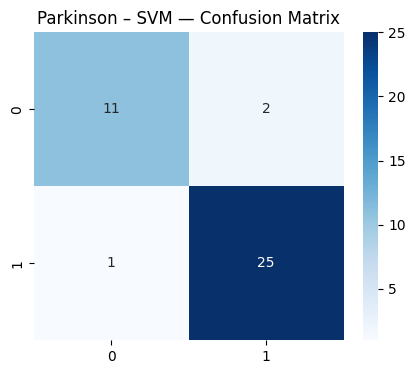


MODEL: Parkinson – RandomForest
Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.96      0.92      0.94        26

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.92        39
weighted avg       0.93      0.92      0.92        39



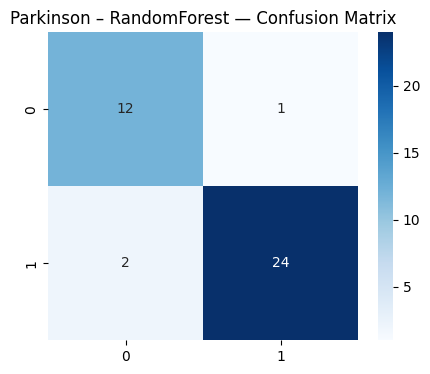


MODEL: Parkinson – XGBoost
Accuracy: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.96      0.92      0.94        26

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.92        39
weighted avg       0.93      0.92      0.92        39



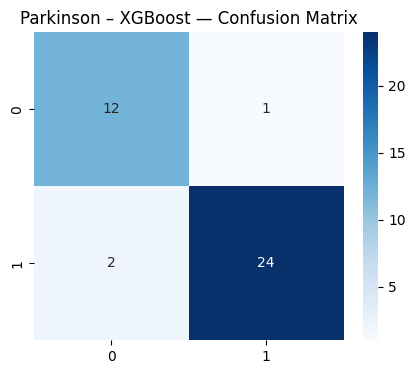


MODEL: Heart – SVM
Accuracy: 0.819672131147541
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        32
           1       0.85      0.76      0.80        29

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



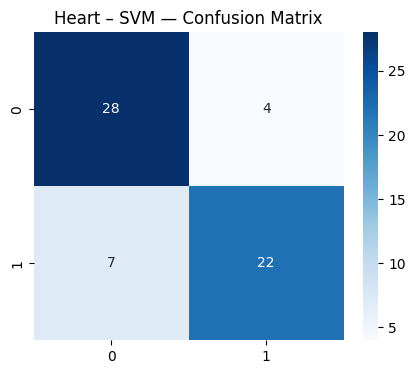


MODEL: Heart – RandomForest
Accuracy: 0.8524590163934426
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.81      0.90      0.85        29

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



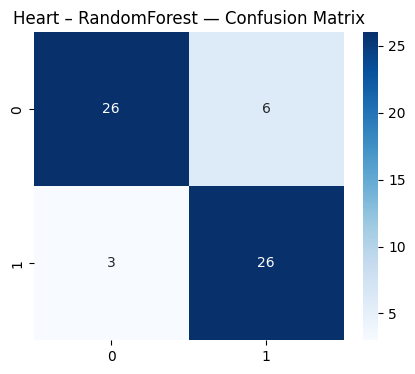


MODEL: Heart – XGBoost
Accuracy: 0.8032786885245902
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        32
           1       0.76      0.86      0.81        29

    accuracy                           0.80        61
   macro avg       0.81      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61



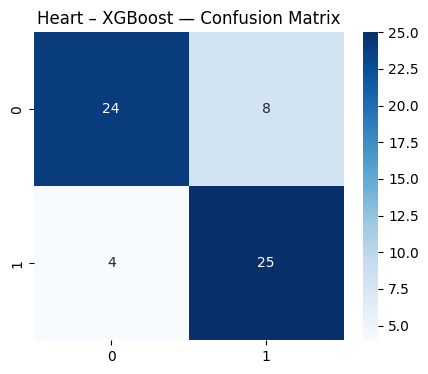


MODEL: Diabetes – SVM
Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.60      0.75      0.67        20
           1       0.67      0.50      0.57        20

    accuracy                           0.62        40
   macro avg       0.63      0.62      0.62        40
weighted avg       0.63      0.62      0.62        40



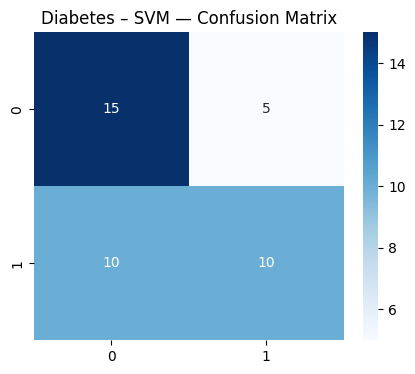


MODEL: Diabetes – RandomForest
Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        20
           1       0.75      0.60      0.67        20

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40



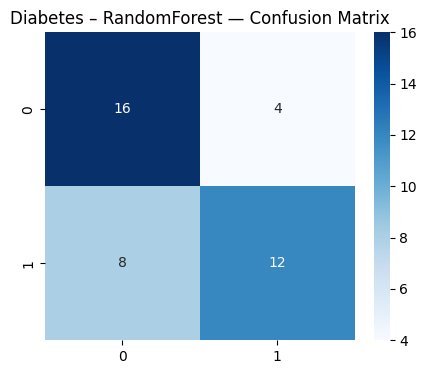


MODEL: Diabetes – XGBoost
Accuracy: 0.725
              precision    recall  f1-score   support

           0       0.68      0.85      0.76        20
           1       0.80      0.60      0.69        20

    accuracy                           0.72        40
   macro avg       0.74      0.72      0.72        40
weighted avg       0.74      0.72      0.72        40



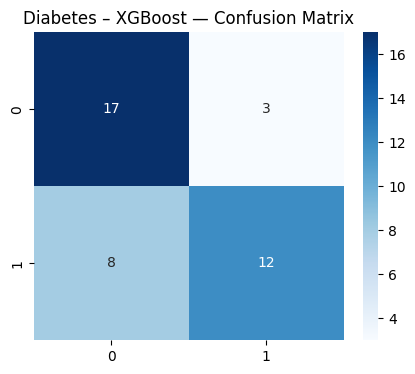

In [ ]:
# Evaluate ML models
for k, v in ml_p.items():
    evaluate(v, Xp_te, yp_te, f"Parkinson – {k}")

for k, v in ml_h.items():
    evaluate(v, Xh_te, yh_te, f"Heart – {k}")

for k, v in ml_d.items():
    evaluate(v, Xd_te, yd_te, f"Diabetes – {k}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step

MODEL: Parkinson – DL
Accuracy: 0.7948717948717948
              precision    recall  f1-score   support

           0       0.65      0.85      0.73        13
           1       0.91      0.77      0.83        26

    accuracy                           0.79        39
   macro avg       0.78      0.81      0.78        39
weighted avg       0.82      0.79      0.80        39



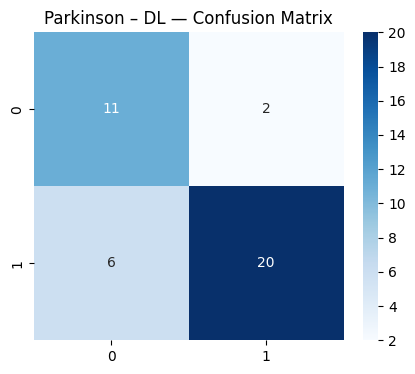

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

MODEL: Heart – DL
Accuracy: 0.8032786885245902
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.74      0.90      0.81        29

    accuracy                           0.80        61
   macro avg       0.81      0.81      0.80        61
weighted avg       0.82      0.80      0.80        61



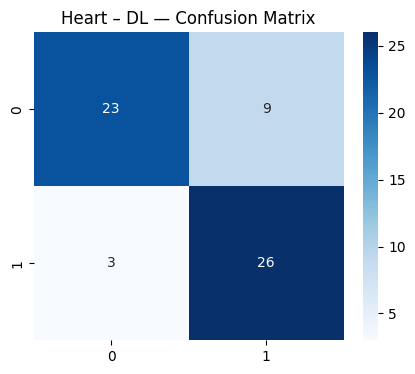

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

MODEL: Diabetes – DL
Accuracy: 0.725
              precision    recall  f1-score   support

           0       0.68      0.85      0.76        20
           1       0.80      0.60      0.69        20

    accuracy                           0.72        40
   macro avg       0.74      0.72      0.72        40
weighted avg       0.74      0.72      0.72        40



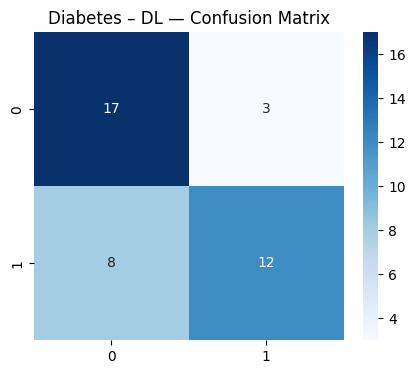

In [ ]:
evaluate(dl_p, Xp_te, yp_te, "Parkinson – DL")
evaluate(dl_h, Xh_te, yh_te, "Heart – DL")
evaluate(dl_d, Xd_te, yd_te, "Diabetes – DL")


In [ ]:
def get_acc(model, Xte, yte):
    y_pred = model.predict(Xte)
    if y_pred.ndim > 1:
        y_pred = (y_pred > 0.5).astype(int)
    return accuracy_score(yte, y_pred)

accuracy_scores = {
    "Parkinson_SVM": get_acc(ml_p["SVM"], Xp_te, yp_te),
    "Parkinson_RF": get_acc(ml_p["RandomForest"], Xp_te, yp_te),
    "Parkinson_XGBoost": get_acc(ml_p["XGBoost"], Xp_te, yp_te),
    "Parkinson_DL": get_acc(dl_p, Xp_te, yp_te),

    "Heart_SVM": get_acc(ml_h["SVM"], Xh_te, yh_te),
    "Heart_RF": get_acc(ml_h["RandomForest"], Xh_te, yh_te),
    "Heart_XGBoost": get_acc(ml_h["XGBoost"], Xh_te, yh_te),
    "Heart_DL": get_acc(dl_h, Xh_te, yh_te),

    "Diabetes_SVM": get_acc(ml_d["SVM"], Xd_te, yd_te),
    "Diabetes_RF": get_acc(ml_d["RandomForest"], Xd_te, yd_te),
    "Diabetes_XGBoost": get_acc(ml_d["XGBoost"], Xd_te, yd_te),
    "Diabetes_DL": get_acc(dl_d, Xd_te, yd_te),
}

import pandas as pd
pd.DataFrame.from_dict(accuracy_scores, orient='index', columns=['Accuracy'])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


,Accuracy
Parkinson_SVM,0.923077
Parkinson_RF,0.923077
Parkinson_XGBoost,0.923077
Parkinson_DL,0.794872
Heart_SVM,0.819672
Heart_RF,0.852459
Heart_XGBoost,0.803279
Heart_DL,0.803279
Diabetes_SVM,0.625000
Diabetes_RF,0.700000


In [ ]:
import joblib
import os

SAVE_DIR = "/content/drive/MyDrive/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save ML models
for name, model_dict in zip(["Parkinson", "Heart", "Diabetes"], [ml_p, ml_h, ml_d]):
    for mname, mobj in model_dict.items():
        joblib.dump(mobj, f"{SAVE_DIR}/{name}_{mname}.joblib")

# Save DL models
dl_p.save(f"{SAVE_DIR}/Parkinson_DL.h5")
dl_h.save(f"{SAVE_DIR}/Heart_DL.h5")
dl_d.save(f"{SAVE_DIR}/Diabetes_DL.h5")

print("All models saved successfully!")


All models saved successfully!
